In [1]:
!pip install matplotlib
!pip install networkx
!pip install tsplib95
!pip install vrplib

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import tsplib95
import itertools as it
import random
import vrplib
import math
import pandas as pd
import time
from copy import deepcopy
from operator import attrgetter

In [3]:
def draw_graph(G):
    pos = {i: (data['x'], data['y']) for i, data in G.nodes(data=True)}
    plt.figure(figsize=(8, 6))    
    nx.draw_networkx_nodes(G, pos, node_size=300, node_color='lightblue')
    nx.draw_networkx_edges(G, pos)
    labels = {i: f'{i} (d={data["demand"]})' for i, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=10)
    plt.title("Gráfico de nodos VRP (Vehicle Routing Problem)")
    plt.xlabel("Coordenada X")
    plt.ylabel("Coordenada Y")
    plt.grid(True)
    plt.show()

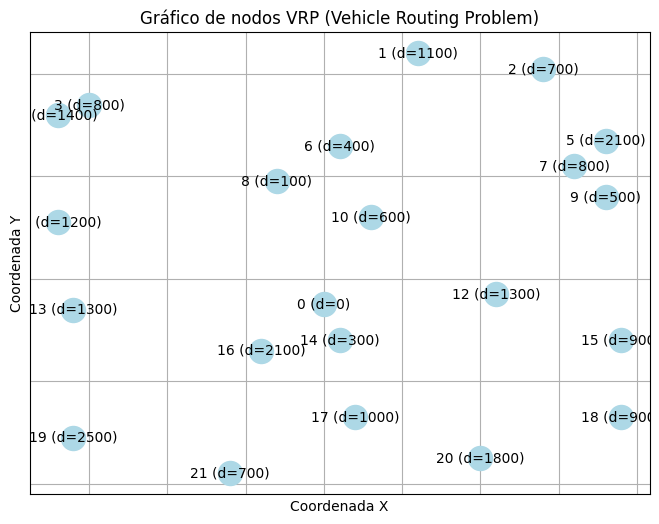

In [4]:
G = nx.MultiDiGraph()

instance = vrplib.read_instance("./Vrp-Set-E/E/E-n22-k4.vrp")
demand = instance['demand']
nodes_coords = instance['node_coord']
for i, (x, y) in enumerate(nodes_coords):
    G.add_node(i, x=int(x), y=int(y), demand=int(demand[i]))

G.edges(data=True)
draw_graph(G)

In [5]:
def distancia_euclidiana(node1, node2, G):
    x1, y1 = G.nodes[node1]['x'], G.nodes[node1]['y']
    x2, y2 = G.nodes[node2]['x'], G.nodes[node2]['y']
    return math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)

def calcular_custo(rota, G):
    custo = 0
    for i in range(len(rota) - 1):
        custo += distancia_euclidiana(rota[i], rota[i+1], G)
    return custo

def calcular_custo_total(rotas, G):
    return sum(calcular_custo(rota, G) for rota in rotas)

In [ ]:
def inicializar_solucao(G, capacidade):
    deposito = 0
    nos = list(G.nodes)
    nos.remove(deposito)
    random.shuffle(nos)
    
    rotas = []
    rota_atual = [deposito]
    capacidade_atual = 0

    for no in nos:
        demanda = G.nodes[no]['demand']
        if capacidade_atual + demanda > capacidade:
            rota_atual.append(deposito)
            rotas.append(rota_atual)
            rota_atual = [deposito]
            capacidade_atual = 0
        rota_atual.append(no)
        capacidade_atual += demanda

    rota_atual.append(deposito)
    rotas.append(rota_atual)

    return rotas

In [7]:
def swap_move(rotas, capacidades, demandas, taxa_mutacao):
    if random.random() < taxa_mutacao and len(rotas) > 1:
        r1, r2 = random.sample(rotas, 2)
        
        if len(r1) > 2 and len(r2) > 2:
            i, j = random.randint(1, len(r1) - 2), random.randint(1, len(r2) - 2)
            
            cliente1, cliente2 = r1[i], r2[j]
            carga_r1 = sum(demandas[n] for n in r1) - demadas[cliente1] + demandas[cliente2]
            carga_r2 = sum(demandas[n] for n in r2) - demandas[cliente2] + demandas[cliente1]
            
            if carga_r1 <= capacidades and carga_r2 <= capacidades:
                r1[i], r2[j] = r2[j], r1[i] 
    
    return rotas

def selecao(populacao, G, elitismo):
    populacao.sort(key=lambda x: calcular_custo_total(x, G))
    return populacao[:elitismo] + random.sample(populacao[elitismo:], len(populacao) // 2 - elitismo)

def crossover(pai1, pai2):
    ponto_corte = random.randint(1, len(pai1)-2)
    filho = pai1[:ponto_corte] + [no for no in pai2 if no not in pai1[:ponto_corte]]
    return filho

def mutacao(rota, taxa_mutacao, capacidade):
    if random.random() < taxa_mutacao and len(rota) > 3:
        i, j = random.sample(range(1, len(rota) - 1), 2)
        rota[i], rota[j] = rota[j], rota[i]
    return rota

def gerar_populacao_inicial(G, capacidade, tamanho_populacao):
    return [inicializar_solucao(G, capacidade) for _ in range(tamanho_populacao)]

def migracao(ilhas, taxa_migracao, tamanho_migracao, topologia):
    if topologia == 'anel':
        for i in range(len(ilhas)):
            destino = (i + 1) % len(ilhas)
            migrantes = ilhas[i][:tamanho_migracao]
            ilhas[destino].extend(migrantes)
            ilhas[i] = ilhas[i][tamanho_migracao:]
    elif topologia == 'totalmente_conectado':
        for i in range(len(ilhas)):
            destinos = [j for j in range(len(ilhas)) if j != i]
            destino = random.choice(destinos)
            migrantes = ilhas[i][:tamanho_migracao]
            ilhas[destino].extend(migrantes)
            ilhas[i] = ilhas[i][tamanho_migracao:]

In [8]:
def gerar_populacao_inicial(G, capacidade, tamanho_populacao):
    return [inicializar_solucao(G, capacidade) for _ in range(tamanho_populacao)]

In [9]:
def island_model(G, capacidade, num_ilhas, tamanho_populacao, num_geracoes, taxa_mutacao, taxa_migracao, tamanho_migracao, intervalo_migracao, elitismo, topologia):
    ilhas = [gerar_populacao_inicial(G, capacidade, tamanho_populacao) for _ in range(num_ilhas)]
    melhor_solucao = None
    melhor_custo = float('inf')
    
    for geracao in range(num_geracoes):
        for i in range(num_ilhas):
            ilhas[i] = selecao(ilhas[i], G, elitismo)
            nova_geracao = deepcopy(ilhas[i])
            while len(nova_geracao) < tamanho_populacao:
                pais = random.sample(ilhas[i], 2)
                filho = crossover(pais[0], pais[1])
                filho = [mutacao(rota, taxa_mutacao, capacidade) for rota in filho]
                nova_geracao.append(filho)
            ilhas[i] = nova_geracao
        
        if geracao % intervalo_migracao == 0:
            migracao(ilhas, taxa_migracao, tamanho_migracao, topologia)
        
        for ilha in ilhas:
            for solucao in ilha:
                custo = calcular_custo_total(solucao, G)
                if custo < melhor_custo:
                    melhor_solucao = solucao
                    melhor_custo = custo
    
    return melhor_solucao, melhor_custo

In [10]:
capacidade = 6000
tamanho_populacao = 200
num_ilhas = 3
elitismo = 100
num_geracoes = 1000
taxa_mutacao = 0.1
taxa_migracao = 0.1
tamanho_migracao = max(1, int(tamanho_populacao * taxa_migracao))
intervalo_migracao = 10
topologia = 'anel'

In [11]:
melhor_solucao, melhor_custo = island_model(G, capacidade, num_ilhas, tamanho_populacao, num_geracoes, taxa_mutacao, taxa_migracao, tamanho_migracao, intervalo_migracao, elitismo, topologia)
print("Melhor solução:", melhor_solucao)
print("Custo da melhor solução:", melhor_custo)

Melhor solução: [[0, 21, 19, 16, 0], [0, 7, 5, 2, 1, 6, 8, 0], [0, 16, 4, 3, 9, 10, 0], [0, 14, 18, 20, 21, 17, 13, 0], [0, 11, 19, 15, 12, 0]]
Custo da melhor solução: 562.5827013316679


In [17]:
def testar_parametros(combinacoes_parametros, G, capacidade, num_testes, taxa_mutacao, taxa_migracao, tamanho_migracao, intervalo_migracao, elitismo, topologia):
    resultados = []
    
    for num_ilhas, num_geracoes, tamanho_populacao in combinacoes_parametros:
        custos = []
        tempos = []
        melhores_solucoes = []

        for _ in range(num_testes):
            inicio = time.time()
            melhor_solucao, melhor_custo = island_model(G, capacidade, num_ilhas, tamanho_populacao, num_geracoes, taxa_mutacao, taxa_migracao, tamanho_migracao, intervalo_migracao, elitismo, topologia)
            fim = time.time()

            custos.append(melhor_custo)
            tempos.append((fim - inicio) * 1000)
            melhores_solucoes.append(melhor_solucao)

        media_custos = sum(custos) / num_testes
        melhor_custo_global = min(custos)
        media_tempo = sum(tempos) / num_testes
        
        melhor_solucao_global = melhores_solucoes[custos.index(melhor_custo_global)]
        
        resultados.append({
            'Número de ilhas': num_ilhas,
            'Máximo de gerações': num_geracoes,
            'Tamanho populacao': tamanho_populacao,
            'Média dos custos': media_custos,
            'Melhor custo': melhor_custo_global,
            'Média do tempo (ms)': media_tempo,
            'Melhor solução': melhor_solucao_global,
        })
        
        print(f"Parâmetros: Ilhas={num_ilhas}, Gerações={num_geracoes}, Tamanho Populacao={tamanho_populacao} -> Média Custo: {media_custos:.2f}, Melhor Custo: {melhor_custo_global:.2f}, Média Tempo: {media_tempo:.2f} ms")
    
    return resultados

In [24]:
num_ilhas = [2, 4, 6, 8]
num_geracoes = [200, 400, 600, 800, 1000]
tamanho_populacao = [100, 150, 200]
combinacoes_parametros = list(it.product(num_ilhas, num_geracoes, tamanho_populacao))

In [22]:
capacidade = 6000
elitismo = 50
taxa_mutacao = 0.2
taxa_migracao = 0.1
tamanho_migracao = 5
intervalo_migracao = 300
topologia = 'anel'

In [25]:
resultados = testar_parametros(combinacoes_parametros, G, capacidade, 10, 
                                taxa_mutacao, taxa_migracao, tamanho_migracao, intervalo_migracao, elitismo, topologia)

df_resultados = pd.DataFrame(resultados)
print(df_resultados.sort_values(by='Média dos custos').head(10))

Parâmetros: Ilhas=2, Gerações=200, Tamanho Populacao=100 -> Média Custo: 616.54, Melhor Custo: 512.65, Média Tempo: 1424.22 ms
Parâmetros: Ilhas=2, Gerações=200, Tamanho Populacao=150 -> Média Custo: 603.46, Melhor Custo: 556.41, Média Tempo: 2645.00 ms
Parâmetros: Ilhas=2, Gerações=200, Tamanho Populacao=200 -> Média Custo: 655.82, Melhor Custo: 611.74, Média Tempo: 5031.80 ms
Parâmetros: Ilhas=2, Gerações=400, Tamanho Populacao=100 -> Média Custo: 573.43, Melhor Custo: 507.19, Média Tempo: 2706.84 ms
Parâmetros: Ilhas=2, Gerações=400, Tamanho Populacao=150 -> Média Custo: 554.45, Melhor Custo: 518.01, Média Tempo: 5086.98 ms
Parâmetros: Ilhas=2, Gerações=400, Tamanho Populacao=200 -> Média Custo: 586.91, Melhor Custo: 533.02, Média Tempo: 9456.10 ms
Parâmetros: Ilhas=2, Gerações=600, Tamanho Populacao=100 -> Média Custo: 563.60, Melhor Custo: 453.13, Média Tempo: 4014.12 ms
Parâmetros: Ilhas=2, Gerações=600, Tamanho Populacao=150 -> Média Custo: 551.90, Melhor Custo: 492.41, Média Te

KeyboardInterrupt: 